In [1]:
%matplotlib inline
path = "data/redux/"
import utils; reload(utils)
from utils import * #makes it so that we don't need to do utils.(method) when we need to use a method

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
batch_size = 64

## To Do
1. Create a validation set and sample set
2. Move to a new dir for each set
3. Classify cats vs. dogs
4. Finetune and train
5. Submit

# Create Validation set and Sample Set:

%cd

%cd nbs/data/redux

%cd train

%mkdir ../valid

The following glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order

g = glob('*.jpg') #Grabs all jpgs
shuf = np.random.permutation(g) #Shuffles the files so the files in the validation set are customized
for i in range(2000): os.rename(shuf[i], '../valid/' + shuf[i]) #os.rename moves the file to a new location

%pwd

%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

## Now we need to keep the files from sample in our train set too because we need to train a full set later and we use this module:

The shutil module offers a number of high-level operations on files and collections of files. In particular, functions are provided which support file copying and removal. For operations on individual files, see also the os module.

from shutil import copyfile

g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/train/' + shuf[i])

%cd ../valid

g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/valid/' + shuf[i])

# Move to separate dirs for each set

%cd nbs/data/

%cd redux/train/

%mkdir ../train/cats
%mkdir ../train/dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd ../valid

%mkdir ../valid/cats
%mkdir ../valid/dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd ../sample/train/

%mkdir ../train/cats
%mkdir ../train/dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd ../valid

%mkdir ../valid/cats
%mkdir ../valid/dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

# Finetune and Train

In [3]:
%cd
%cd nbs

/home/ubuntu
/home/ubuntu/nbs


In [4]:
from vgg16 import Vgg16

In [5]:
vgg = Vgg16()

In [6]:
batches = vgg.get_batches(path+'train', batch_size=batch_size) #get 4 images at a time
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [11]:
vgg.fit(batches, val_batches, nb_epoch = 1)

Epoch 1/1
23000/23000 [==============================] - 732s - loss: 0.1253 - acc: 0.9684 - val_loss: 0.0685 - val_acc: 0.9810


In [12]:
vgg.model.save_weights(path+'results/ft1.h5')

In [18]:
vgg.model.load_weights(path + "results/ft1.h5")

We do 2 epochs because this increases our accuracy by a lot!

# Submission

First move the test images to a subfolder or else we will get an error

%pwd

In [28]:
%cd
%cd nbs

/home/ubuntu
/home/ubuntu/nbs


In [29]:
%mkdir ../test/unknown
%mv *.jpg unknown/

mkdir: cannot create directory ‘../test/unknown’: No such file or directory
mv: cannot stat '*.jpg': No such file or directory


In [35]:
batches, preds = vgg.test(path + "test/", batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [36]:
filenames = batches.filenames

In [37]:
preds[:5]

array([[  1.0000e+00,   9.1095e-11],
       [  8.8311e-01,   1.1689e-01],
       [  1.0000e+00,   1.0152e-07],
       [  1.0000e+00,   3.5346e-13],
       [  7.0455e-08,   1.0000e+00]], dtype=float32)

In [38]:
filenames[:5]

['unknown/9292.jpg',
 'unknown/12026.jpg',
 'unknown/9688.jpg',
 'unknown/4392.jpg',
 'unknown/779.jpg']

In [39]:
import numpy as np
isdog = np.clip(preds[:,1], 0.05, 0.95) #Everything less than .05 to 0.95
isdog[:5]

array([ 0.05  ,  0.1169,  0.05  ,  0.05  ,  0.95  ], dtype=float32)

In [41]:
ids = [int(f[8:f.find('.')]) for f in filenames] #An int that is from the 8th character to the . in 'unknown/[some int].jpg

In [42]:
subm = np.stack([ids, isdog], axis = 1)

In [43]:
np.savetxt('data/redux/subm98.csv', subm, fmt = '%d,%.5f', header = 'id,label', comments = '')

In [44]:
from IPython.display import FileLink
FileLink('data/redux/subm98.csv')

/home/ubuntu/nbs/data/redux/subm98.csv

# Visualizing results

In [45]:
vgg.model.load_weights(path + "results/ft1.h5")

In [46]:
val_batches, probs = vgg.test(path + 'valid', batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [47]:
labels = val_batches.classes
filenames = val_batches.filenames

In [48]:
probs = probs[:,0]
preds = np.round(1-probs)
probs[:8]

array([ 1.    ,  0.9998,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ], dtype=float32)

In [49]:
n_view = 4

In [51]:
def plots_idx(idx, titles = None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles = titles)

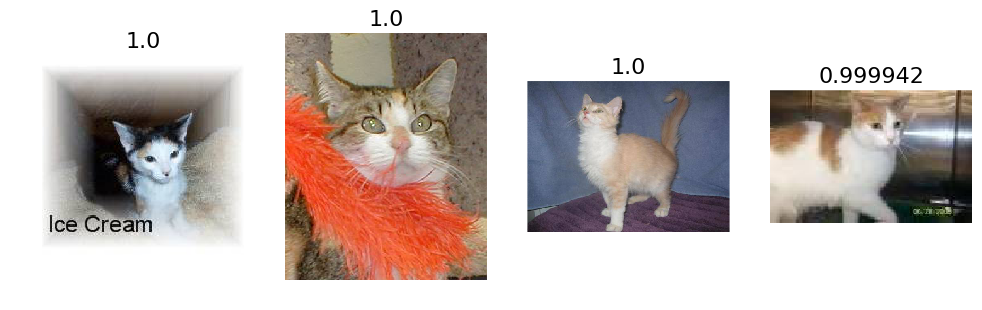

In [52]:
correct = np.where(preds == labels)[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

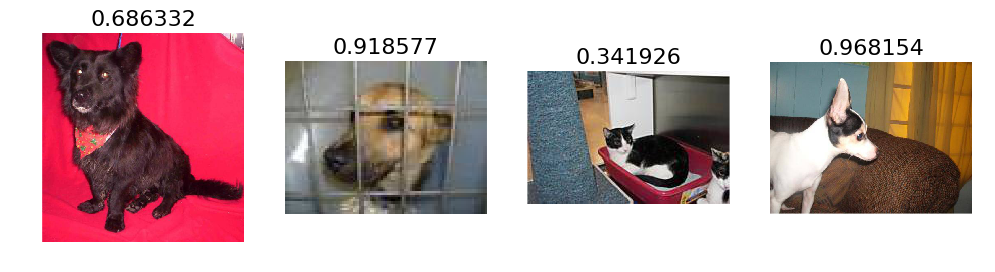

In [54]:
incorrect = np.where(preds != labels)[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

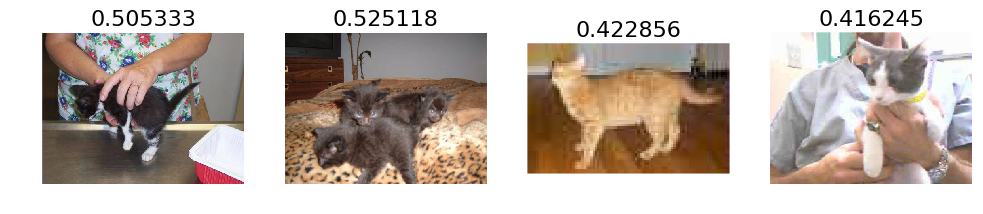

In [55]:
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])